## The conclusion

It is not easy to explain why under the constant disturbance, and in a range close to 0($\bar{\eta}\in [0,2]$), LQR cost has larger variance when $\bar{\eta}$ is small. The simulation trajectories seems to suggest the LQR cost comes from two parts: 1) the difference between the levels at which pure exploitation is conducted. 2) the random exploration actions. When $\bar{\eta}$ is small, LQR costs mainly comes from 1), and there is a large difference in the exploitation level from trial to trial(it is unclear why such difference occurs), so the variance in LQR cost is large. When $\bar{\eta}$ is large, LQR costs become dominated by 2), and at this stage LQR costs are similarly large. 

However, if we increase $\bar{\eta}$ to be extremely large, then the variance go up again.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle as pkl

## The plotting handler

In [2]:
def plot_with_errorband(ax,trial_data,indices = None,label=''):
    mu = np.mean(trial_data,axis=0)
    std = np.std(trial_data,axis=0)

    if indices is None:
        indices = range(len(mu))
    
    ax.plot(indices,np.array(mu),label=label)
    ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [36]:
def plot_all(ax,trial_data,indices = None,label=''):
    
    if indices is None:
        indices = range(len(trial_data[0]))
    for i in range(len(trial_data)):
        ax.plot(indices,trial_data[i],label=label)
#     ax.fill_between(indices,mu+std,mu-std,alpha=0.2)

In [3]:
def cost(Q,hist):
    n_trial = hist.shape[0]
    timesteps = hist.shape[1]
    Q_cost = [hist[i,j].T.dot(Q).dot(hist[i,j]) for i in range(n_trial) for j in range(timesteps)]

    Q_cost = np.array(Q_cost).reshape(n_trial,timesteps)
    return Q_cost

# Total LQR Cost vs $\bar{\eta}$

In [69]:
etas = [0.1,1.0,2.0,5.0,10.0,20.0,40.0,60.0,80.0,100.0]

control_alg = ['SafeLearning','Benchmark']

In [70]:
data = {}
  
costs = {alg:[] for alg in control_alg}

A_errors = {alg:[] for alg in control_alg}
B_errors = {alg:[] for alg in control_alg}

for alg in control_alg:

    for eta in etas:
        with open('./data/{}_eta_{}.pkl'.format(alg,eta),'rb') as f:
            data[eta] = pkl.load(f)

    with open('./data/Parameters.pkl','rb') as f:
        data['Parameters'] = pkl.load(f)

    Q = data['Parameters']['Q']
    R = data['Parameters']['R']
    A = data['Parameters']['A']
    B = data['Parameters']['B']


    mean_cost = []
    std_cost = []

    for eta in etas:
        x_hist = np.array([d['x'] for d in data[eta]])
        u_hist = np.array([d['u'] for d in data[eta]])

        c = np.sum(cost(Q,x_hist),axis=-1)+np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)
        costs[alg].append(c)
        
    costs[alg] = np.array(costs[alg])




Text(0, 0.5, 'LQR Cost')

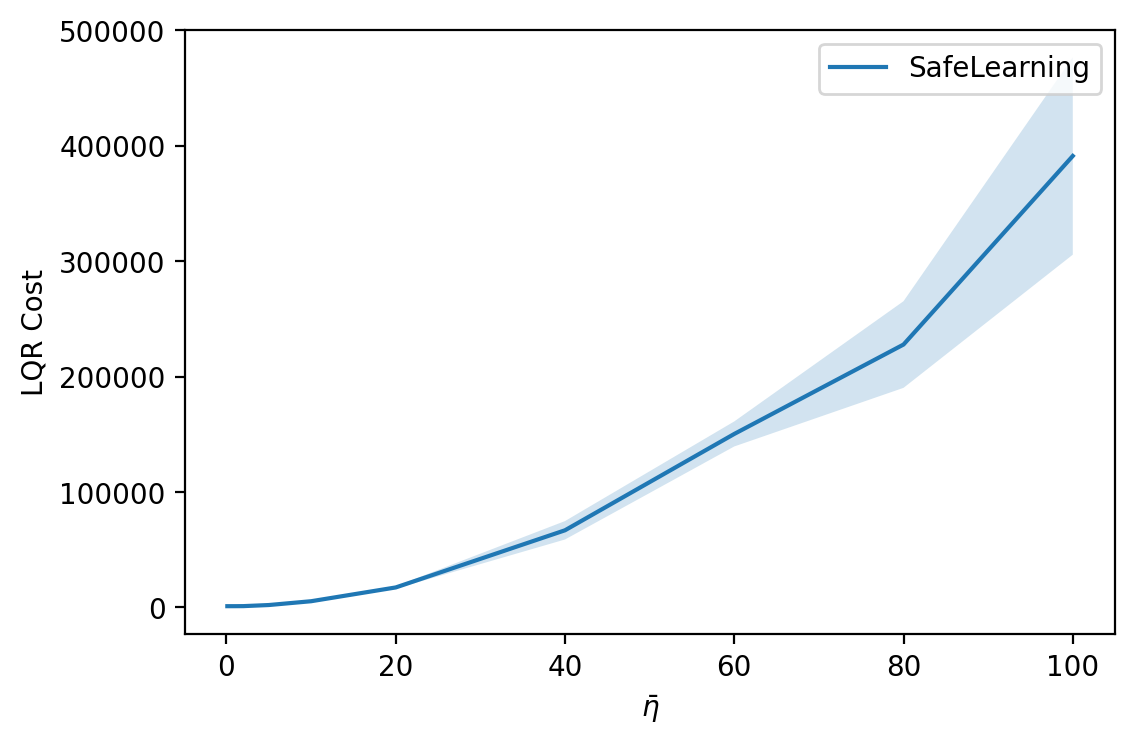

In [71]:

plt.figure(dpi=200)
plot_with_errorband(plt.gca(),costs['SafeLearning'].T,etas,'SafeLearning')


plt.legend()
plt.xlabel(r'$\bar{\eta}}$')
plt.ylabel('LQR Cost')

## To plot:

State, control input vs time under different $\bar{\eta}$.

LQR stage cost vs time under different $\bar{\eta}$.

Estimation error vs time under different $\bar{\eta}$.

In [72]:
norm_order = np.inf


def plot_diagnostics(etas,alg,sample_plot_index = np.array([0])):
  

    data = {}


#     A_errors = {alg:[] for alg in control_alg}
#     B_errors = {alg:[] for alg in control_alg}

#     for alg in control_alg:

    for eta in etas:
        with open('./data/{}_eta_{}.pkl'.format(alg,eta),'rb') as f:
            data[eta] = pkl.load(f)

    with open('./data/Parameters.pkl','rb') as f:
        data['Parameters'] = pkl.load(f)

    Q = data['Parameters']['Q']
    R = data['Parameters']['R']
    A = data['Parameters']['A']
    B = data['Parameters']['B']
    theta = np.concatenate([A,B],axis = -1)



#         mean_cost = []
#         std_cost = []

#         for eta in etas:
#             x_hist = np.array([d['x'] for d in data[eta]])
#             u_hist = np.array([d['u'] for d in data[eta]])

#             c = np.sum(cost(Q,x_hist),axis=-1)+np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)
#             costs[alg].append(c)

#         costs[alg] = np.array(costs[alg])



        ## Trajectory Plots



    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()
        trial_data = np.array([np.array(d['x'])[:,0].flatten() for d in data[eta]])

#         plot_with_errorband(ax,trial_data,label=r'${}:\eta={}$'.format(alg,eta))
        plot_all(ax,trial_data,label=r'${}:\eta={}$'.format(alg,eta))

        ax.set_xlabel('t')
        ax.set_ylabel('x')
        ax.set_title(r'${}:\eta={}$'.format(alg,eta))

#         ax.legend()



    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()

        trial_data = np.array([np.array(d['x'])[:,1].flatten() for d in data[eta]])

#         plot_with_errorband(ax,trial_data,label=r'${}:\eta={}$'.format(alg,eta))
        
        plot_all(ax,trial_data,label=r'${}:\eta={}$'.format(alg,eta))

        ax.set_xlabel('t')
        ax.set_ylabel('v')
        ax.set_title(r'${}:\eta={}$'.format(alg,eta))
        
    x_costs = []
    u_costs = []
    costs = []
    for eta in etas:
        x_hist = np.array([d['x'] for d in data[eta]])
        u_hist = np.array([d['u'] for d in data[eta]])


        x_cost = np.sum(cost(Q,x_hist),axis=-1)
        u_cost = np.sum(cost(R,u_hist[:,:,np.newaxis,np.newaxis]),axis=-1)

        c = x_cost+u_cost
        x_costs.append(x_cost)
        u_costs.append(u_cost)
        costs.append(c)

    print(x_cost.shape,u_cost.shape,len(etas),cost(Q,x_hist).shape,len(costs))
    
    x_costs = np.array(x_costs).T
    u_costs = np.array(u_costs).T
    costs = np.array(costs).T
    
    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),x_costs,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel('x cost')


    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),u_costs,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel('u Cost')

    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),costs,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel('LQR Cost')

#         ax.legend()
#


    for eta in etas[sample_plot_index]:
        plt.figure(dpi=200)
        ax = plt.gca()

        trial_data = [np.array(d['u']) for d in data[eta]]

        plot_all(ax,trial_data,label=r'${}:\eta={}$'.format(alg,eta))

        ax.set_xlabel('t')
        ax.set_ylabel('u')
        ax.set_title(r'${}:\eta={}$'.format(alg,eta))

#         ax.legend()

    

    A_errors = []
    B_errors = []
    theta_errors = []



    for eta in etas:

        thetas = [d['theta'] for d in data[eta]]

        As = np.array([[t[0] for t in theta_hist] for theta_hist in thetas])
        Bs = np.array([[t[1] for t in theta_hist] for theta_hist in thetas])

        thetas  = [np.concatenate(t[-1],axis=-1) for t in thetas]

        # As.shape = (# trials, # refits, x_dim, x_dim)
        # Bs.shape = (# trials, # refits, x_dim, u_dim)

        theta_diff = np.linalg.norm(np.array(thetas)-theta,np.inf,axis=(-1,-2))
        A_diff = np.linalg.norm(As[:,-1,:,:]-A,norm_order,axis=(-1,-2))
        B_diff = np.linalg.norm(Bs[:,-1,:,:]-B,norm_order,axis=(-1,-2))


        theta_errors.append(theta_diff)
        A_errors.append(A_diff)
        B_errors.append(B_diff)



    theta_errors = np.array(theta_errors)
    A_errors = np.array(A_errors)
    B_errors = np.array(B_errors)



    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),theta_errors.T,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{\theta}-\theta||$')
    plt.show()

    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),A_errors.T,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{A}-A||_{\infty}$')
    plt.show()


    plt.figure(dpi=200)
    plot_with_errorband(plt.gca(),B_errors.T,etas,alg)

    plt.legend()
    plt.xlabel(r'$\bar{\eta}}$')
    plt.ylabel(r'$||\hat{B}-B||$')
    plt.show()




In [85]:
# etas = [0.1,1.0,2.0,5.0]
etas = [0.1,0.5,1.0,1.5,2.0,5.0,10.0,20.0,40.0,60.0,80.0,100.0]
# etas = [0.1,0.5,1.0,1.5,2.0,]

(10,) (10,) 12 (10, 400) 12


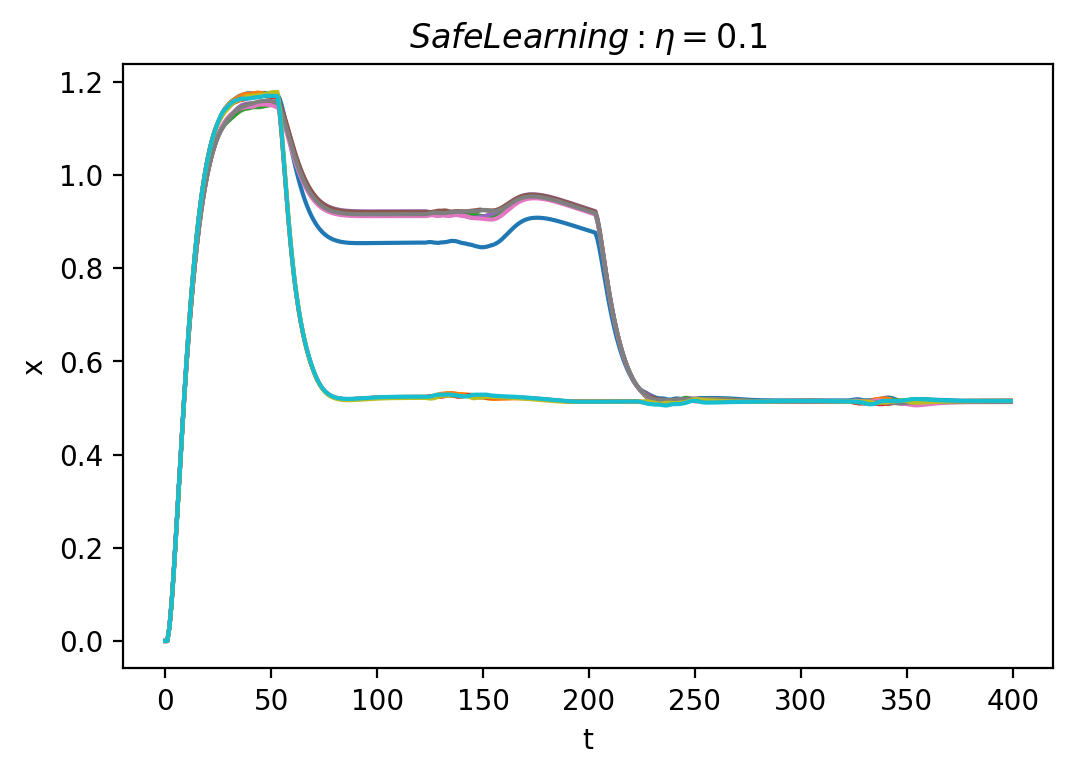

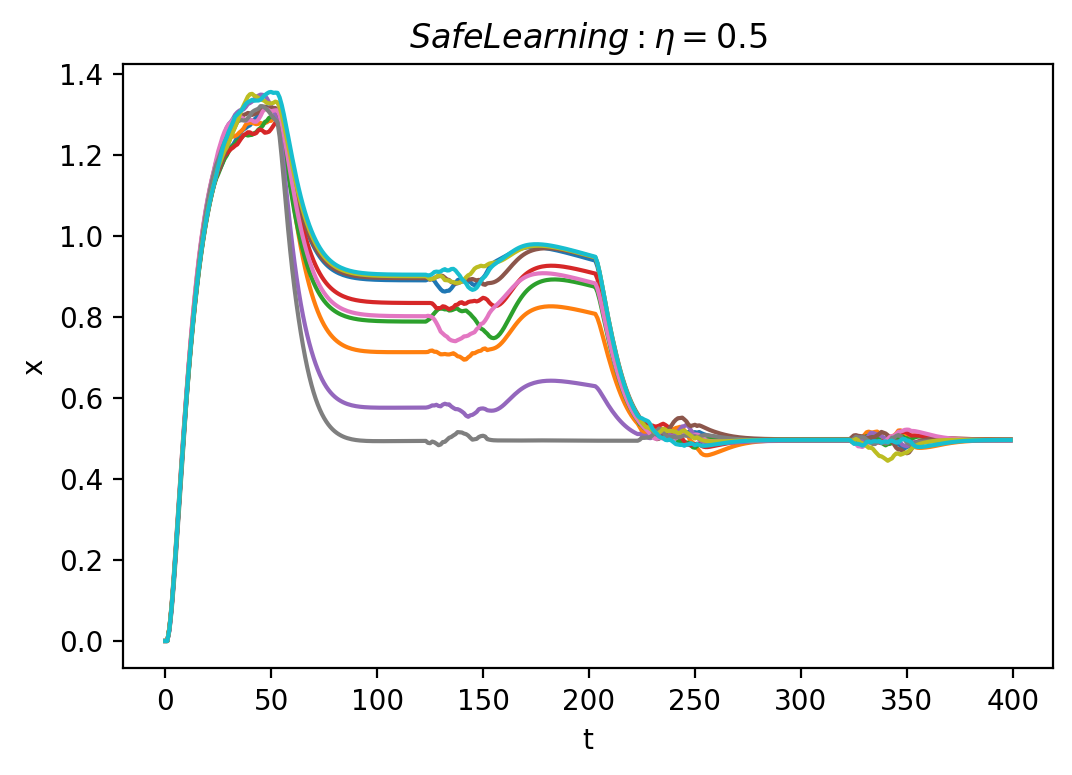

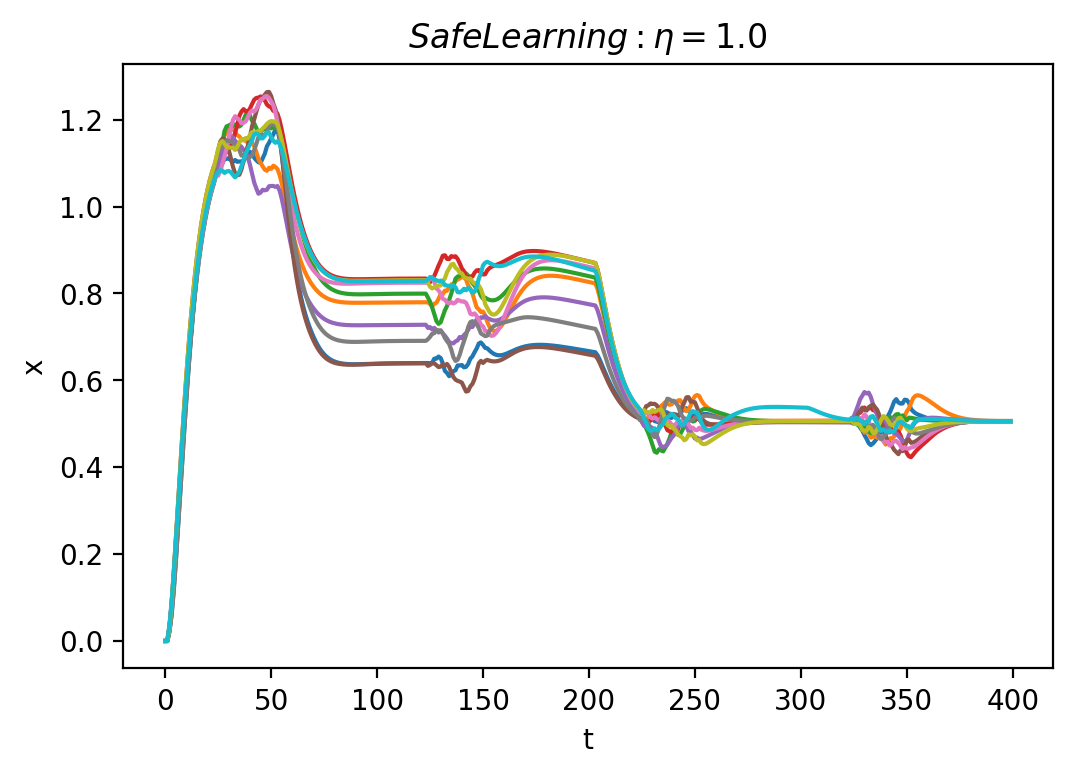

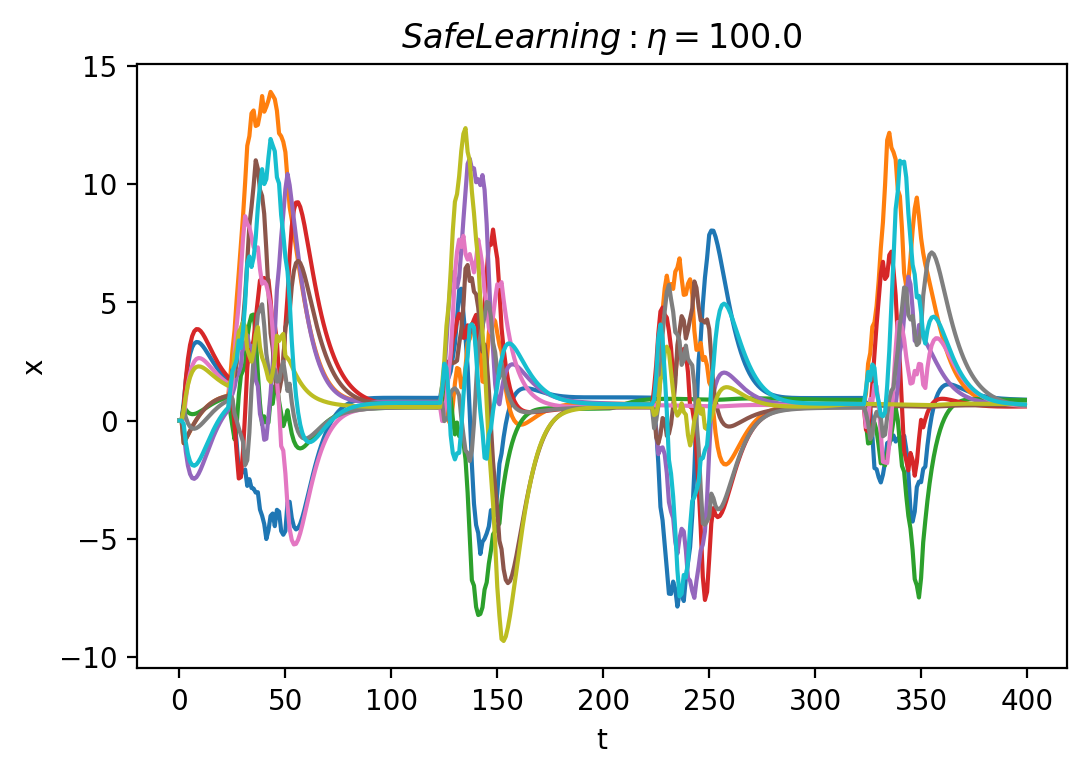

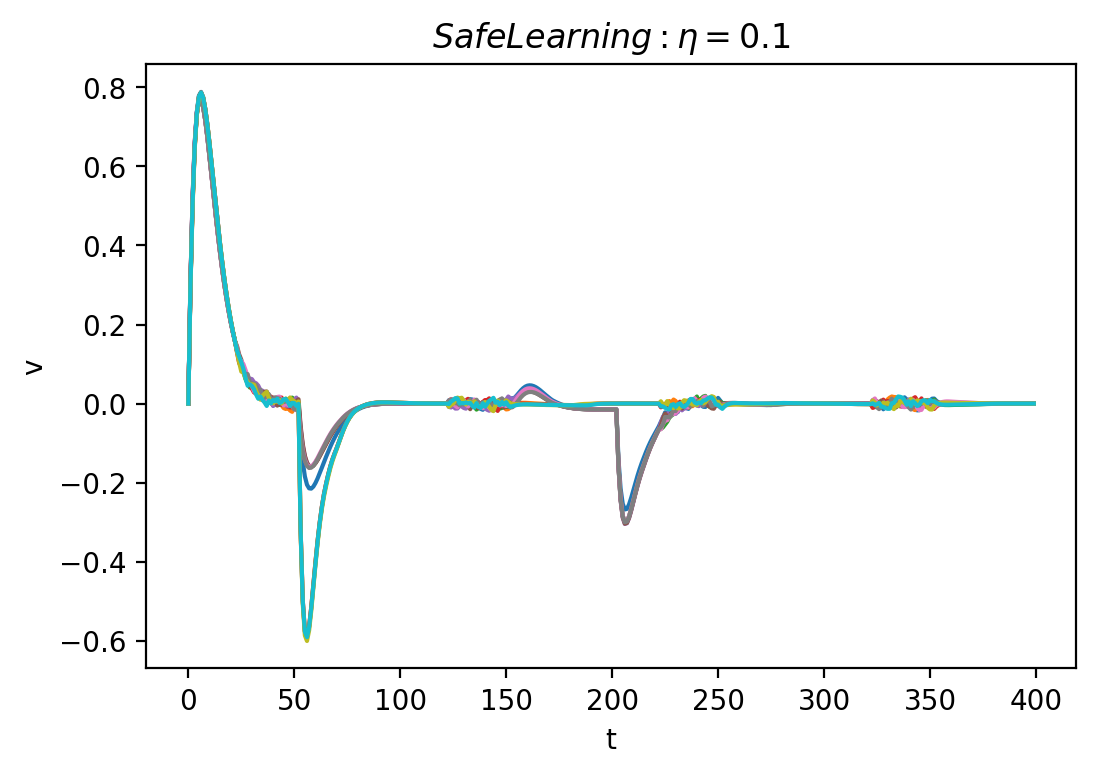

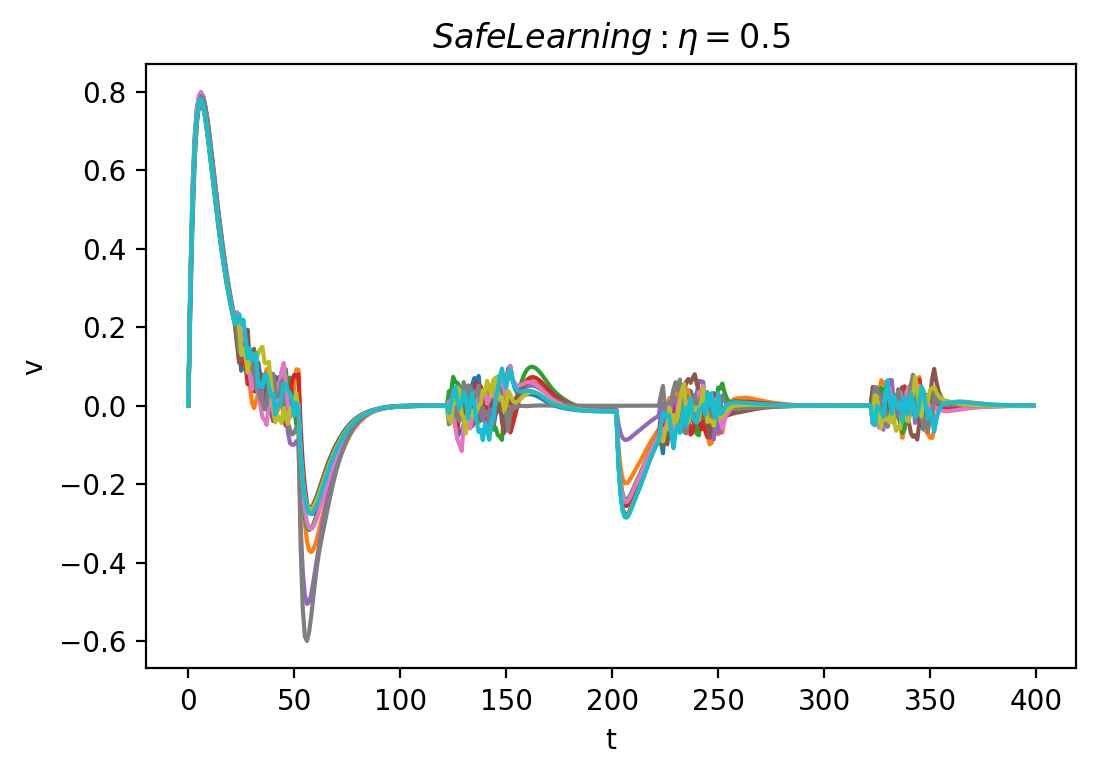

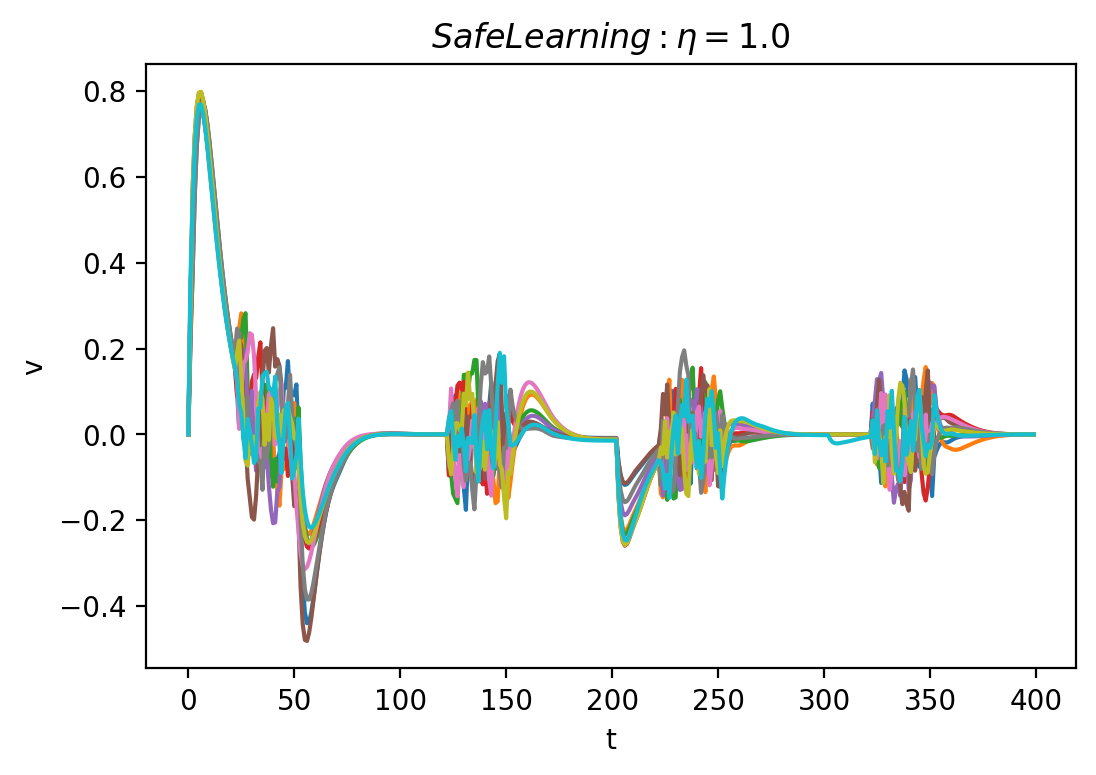

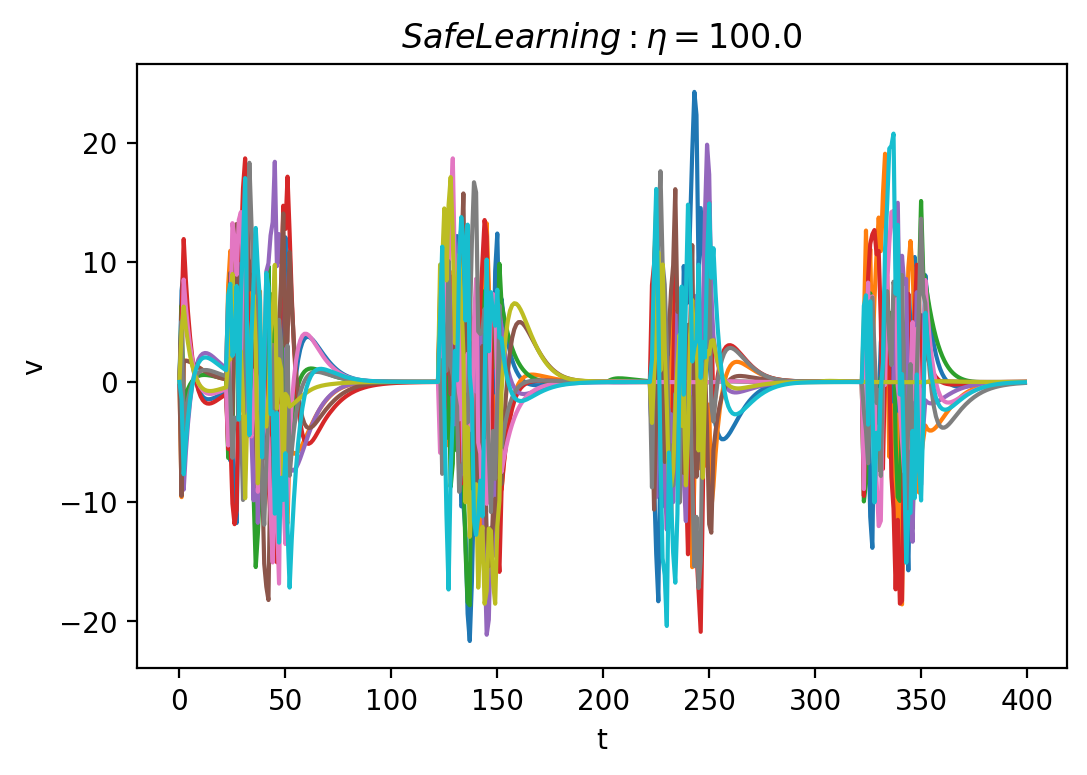

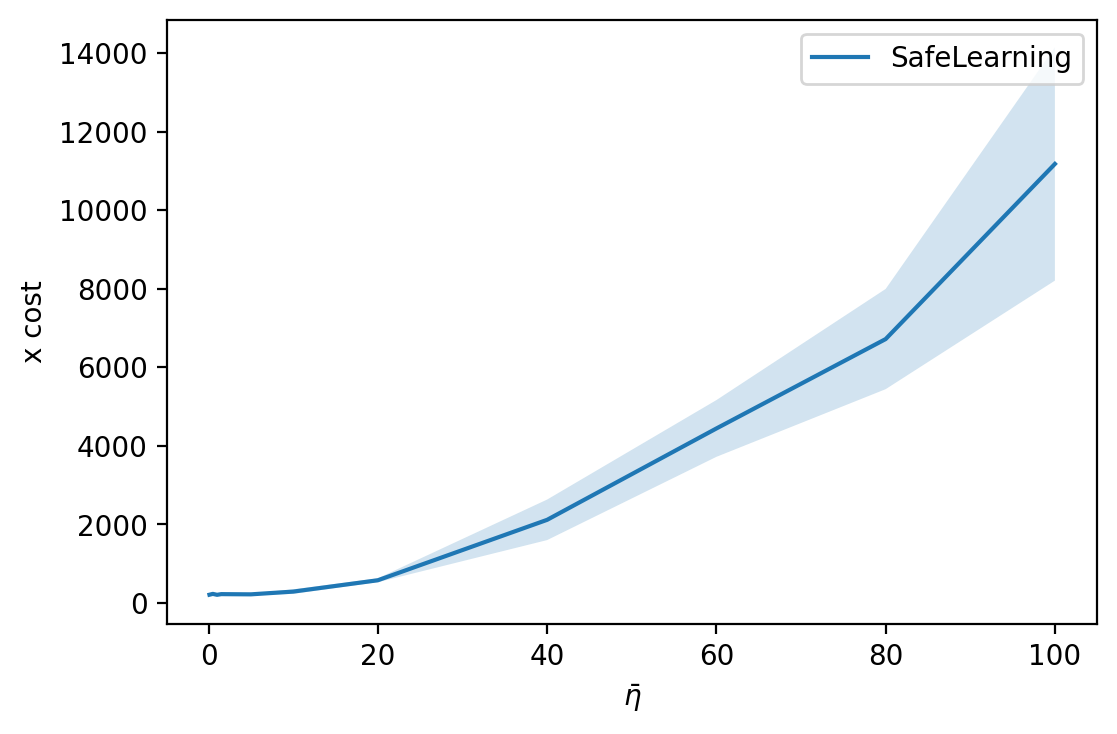

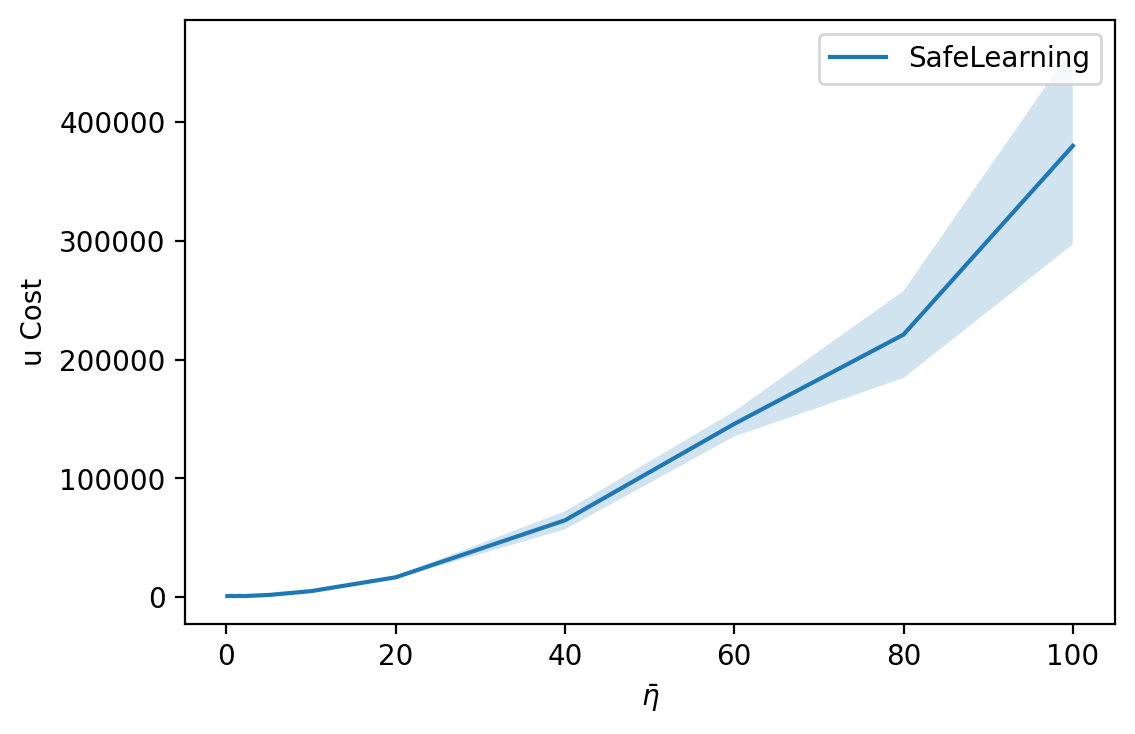

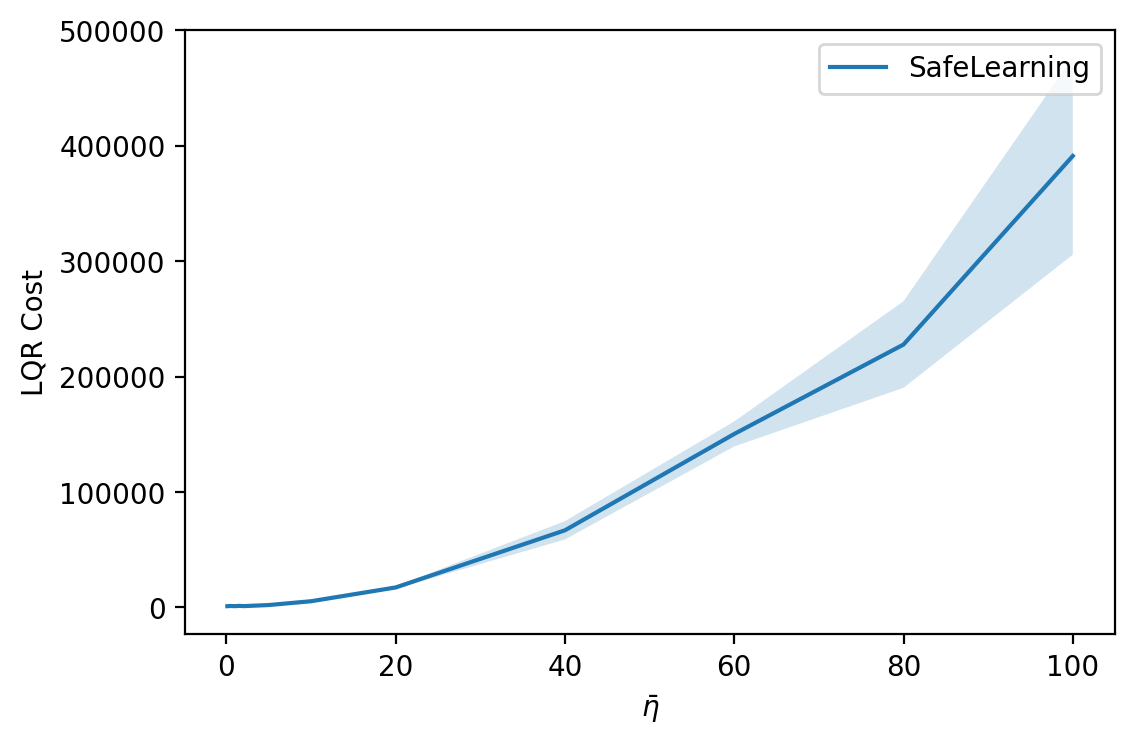

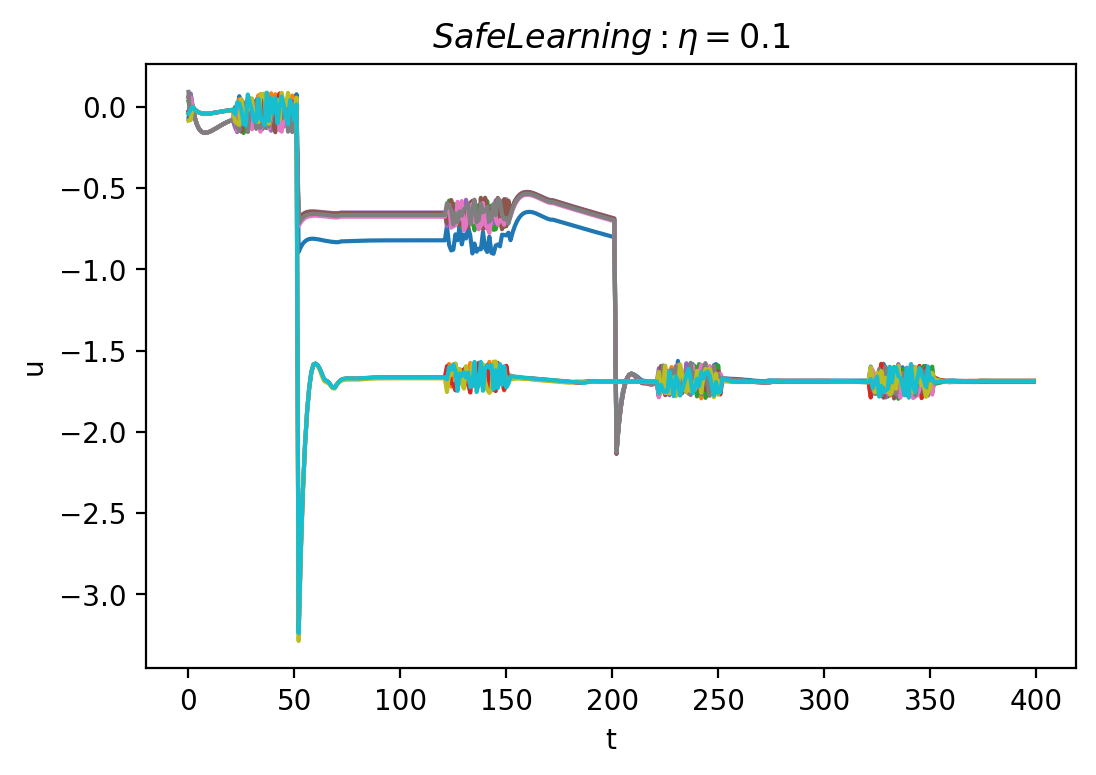

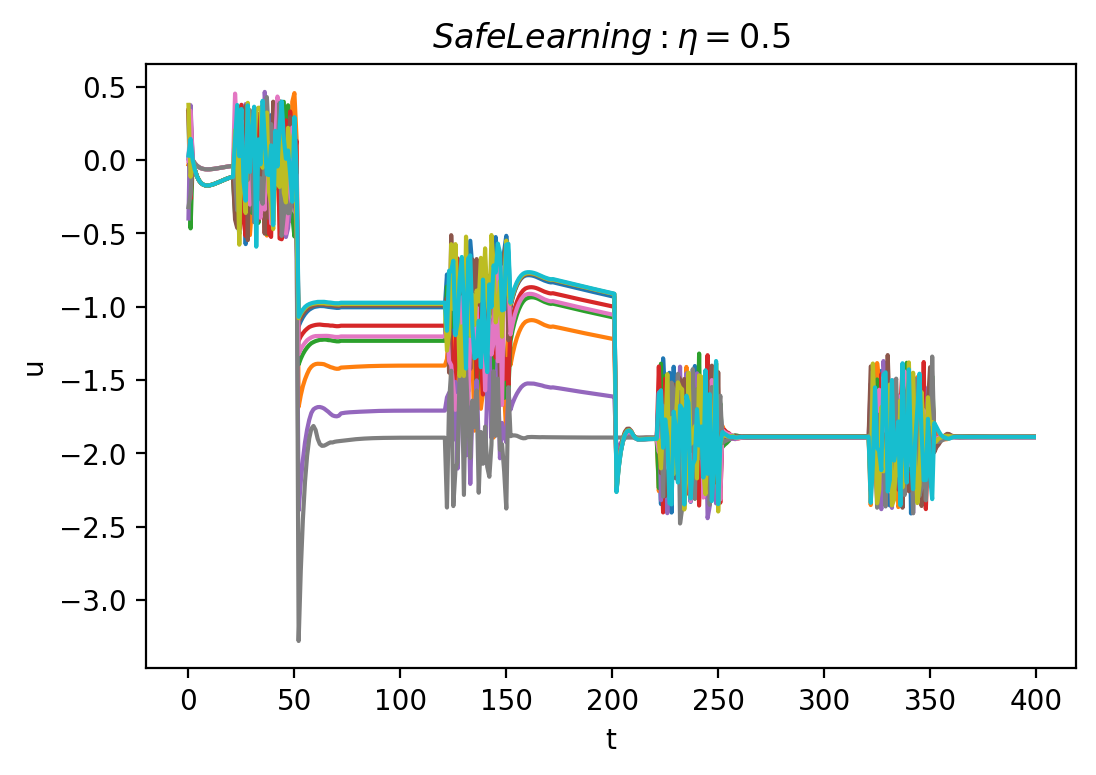

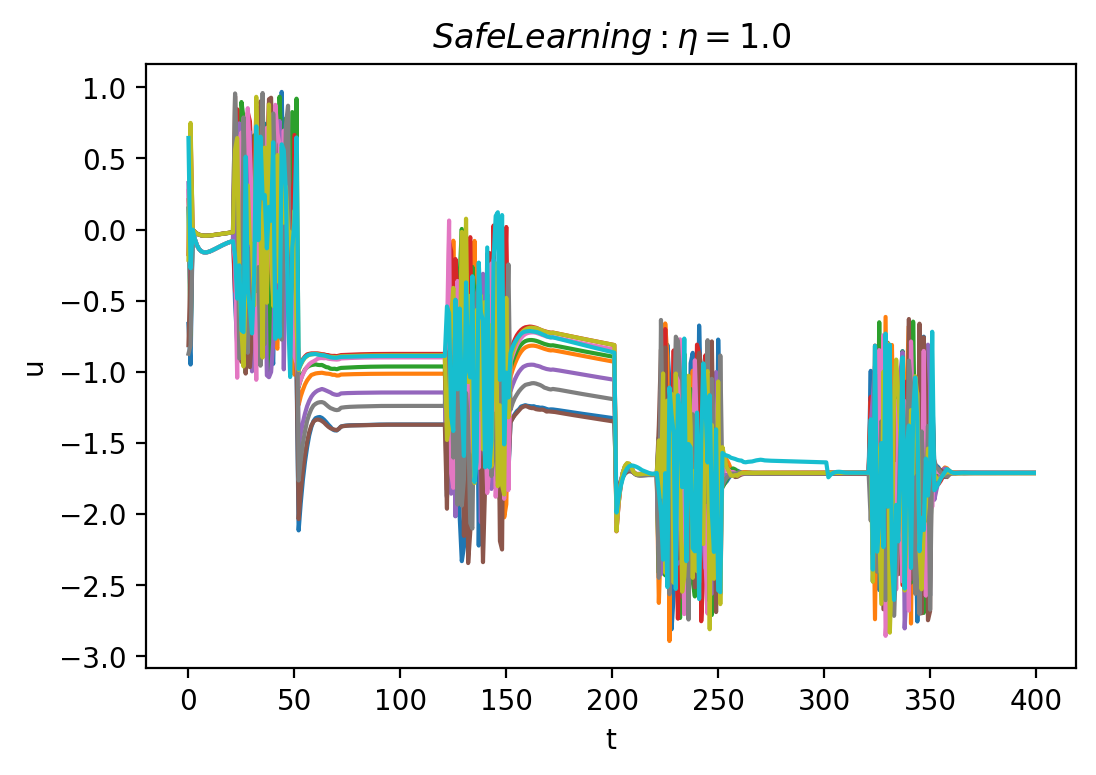

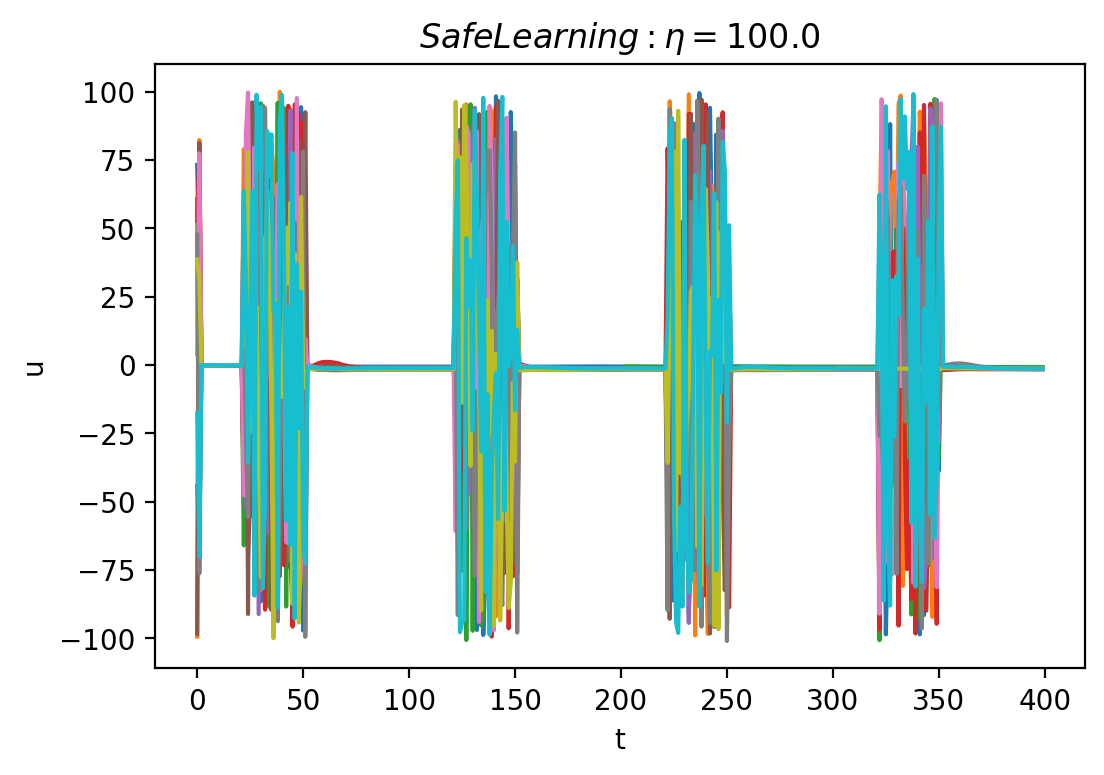

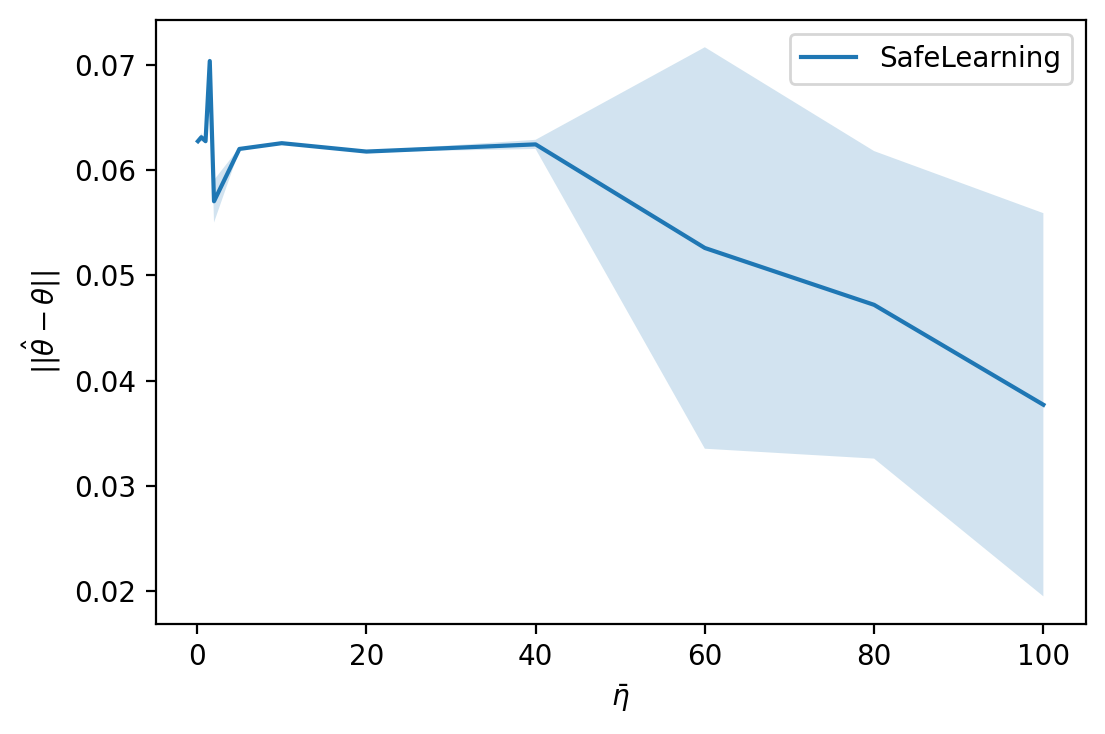

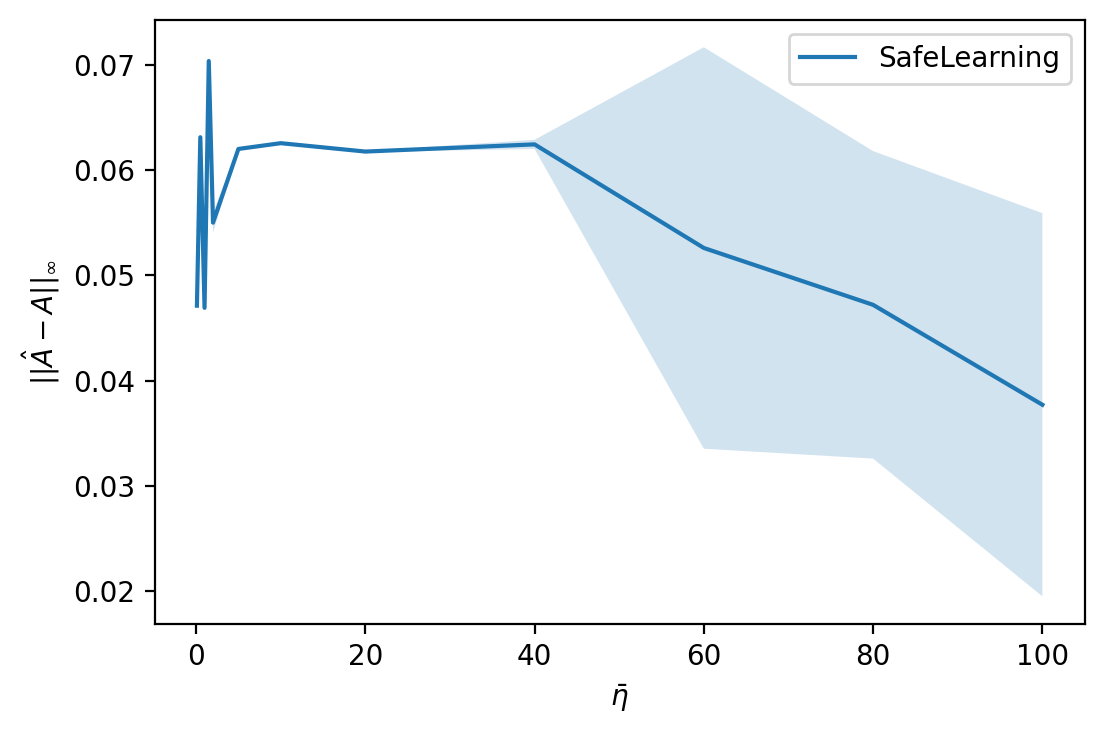

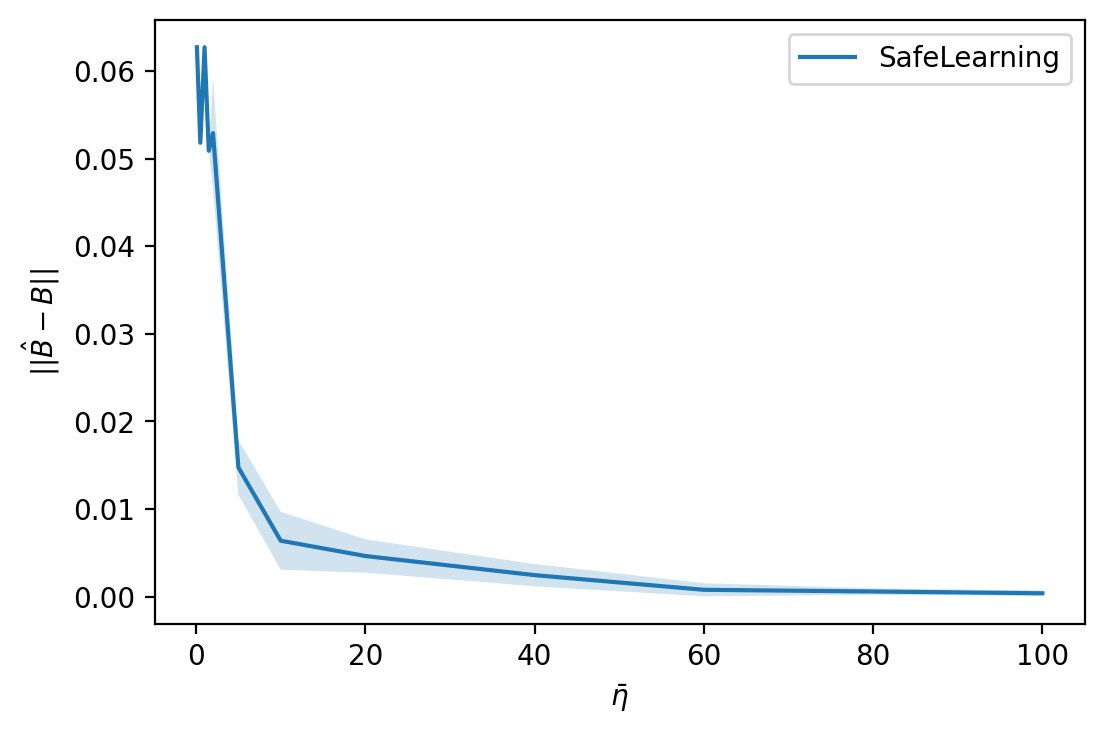

In [86]:
plot_diagnostics(np.array(etas),'SafeLearning',sample_plot_index = np.array([0,1,2,-1]))